# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 16/02/2024

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import glob, pprint
import numpy as np
import h5py
from tqdm.notebook import tqdm

import matplotlib
%matplotlib widget
from matplotlib import pyplot as plt

import utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import properties, dataset

from ImageD11.blobcorrector import eiger_spatial

In [3]:
# OLD DATASETS

# NOTE: For old datasets before the new directory layout structure, we don't distinguish between RAW_DATA and PROCESSED_DATA
# In this case, use this cell to specify where your experimental folder is, and do not run the cell below
# e.g /data/visitor/4752/id11/20210513

### USER: specify your experimental directory

rawdata_path = "/home/esrf/james1997a/Data/ma4752/id11/20210618"

!ls -lrt {rawdata_path}

### USER: specify where you want your processed data to go

processed_data_root_dir = "/home/esrf/james1997a/Data/ma4752/id11/20240118/James"

total 5249
-rwxr-x---  1 backup backup 5372439 Jun 25  2021 ma4752_id11.h5
drwxr-x--- 25 backup backup    4096 Jan 18 06:08 MA4752_S4_2_XRD


In [4]:
# USER: pick a sample and a dataset you want to segment

sample = "MA4752_S4_2_XRD"
dataset = "DTL1z10"

In [5]:
# desination of H5 files

dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")

# USER: specify the path to the parameter file

par_path = 'nickel.par'

e2dx_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf"
e2dy_path = "/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"

In [6]:
# load the dataset from file

ds = ImageD11.sinograms.dataset.load(dset_path)

print(ds)
print(ds.shape)

dataroot = "/home/esrf/james1997a/Data/ma4752/id11/20210618"
analysisroot = "/home/esrf/james1997a/Data/ma4752/id11/20240118/James"
sample = "MA4752_S4_2_XRD"
dset = "DTL1z10"
shape = ( 541, 2896)
# scans 541 from 1.1 to 541.1
(541, 2896)


In [7]:
# Import 2D peaks, make a spatially corrected columnfile, save it

peaks_table = ImageD11.sinograms.properties.pks_table.load(ds.pksfile)

# Grab the 2d peak centroids
peaks_2d = peaks_table.pk2d(ds.omega, ds.dty)
cf_2d = utils.tocolf(peaks_2d, par_path, e2dx_path, e2dy_path)

if os.path.exists(ds.col2dfile):
    os.remove(ds.col2dfile)

# save the 2D peaks to file so we don't have to spatially correct them again
ImageD11.columnfile.colfile_to_hdf(cf_2d, ds.col2dfile)

In [8]:
# We will now generate a cf (columnfile) object for the 4D peaks.
# Will be corrected for detector spatial distortion

peaks_4d = peaks_table.pk2dmerge(ds.omega, ds.dty)
cf_4d = utils.tocolf(peaks_4d, par_path, e2dx_path, e2dy_path)  # spatial correction

# cf_4d = ImageD11.columnfile.colfile_from_dict(peaks_4d)  # no spatial correction
# cf_4d.addcolumn(cf_4d.s_raw, "sc")
# cf_4d.addcolumn(cf_4d.f_raw, "fc")

# cf_4d.parameters.loadparameters(par_path)
# cf_4d.updateGeometry()

# the first thing we should do is create an index column for our 4D peaks
index_column = np.arange(cf_4d.nrows)
cf_4d.addcolumn(index_column, 'index')

# Delete the columnfile output file if it exists

if os.path.exists(ds.col4dfile):
    os.remove(ds.col4dfile)
    
# save the 4D peaks to file so we don't have to spatially correct them again
ImageD11.columnfile.colfile_to_hdf(cf_4d, ds.col4dfile)

In [9]:
# cf_2d = ImageD11.columnfile.colfile_from_hdf(ds.col2dfile)
# cf_2d.parameters.loadparameters(par_path)
# cf_2d.updateGeometry()

In [10]:
# cf_4d = ImageD11.columnfile.colfile_from_hdf(ds.col4dfile)
# cf_4d.parameters.loadparameters(par_path)
# cf_4d.updateGeometry()

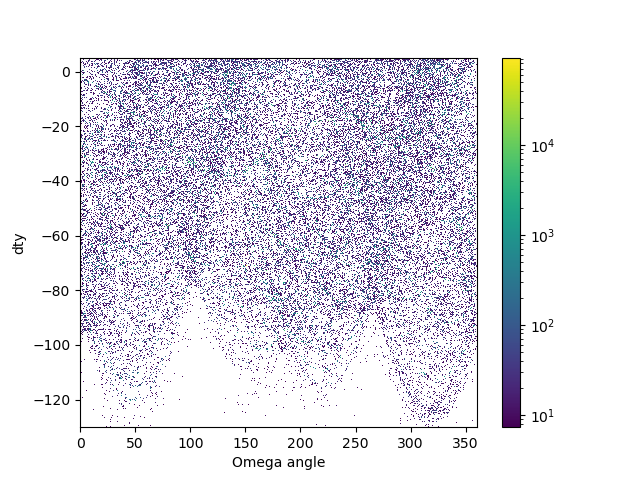

In [11]:
# Generate a mask that selects only 4D peaks greater than 25 pixels in size

m = cf_4d['Number_of_pixels'] > 25

# then plot omega vs dty for all peaks - should look sinusoidal

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(cf_4d['omega'][m], cf_4d['dty'][m], weights=np.sqrt(cf_4d['sum_intensity'][m]), bins=(ds.obinedges, ds.ybinedges), norm=matplotlib.colors.LogNorm())
ax.set_xlabel("Omega angle")
ax.set_ylabel("dty")

fig.colorbar(im, ax=ax)

plt.show()

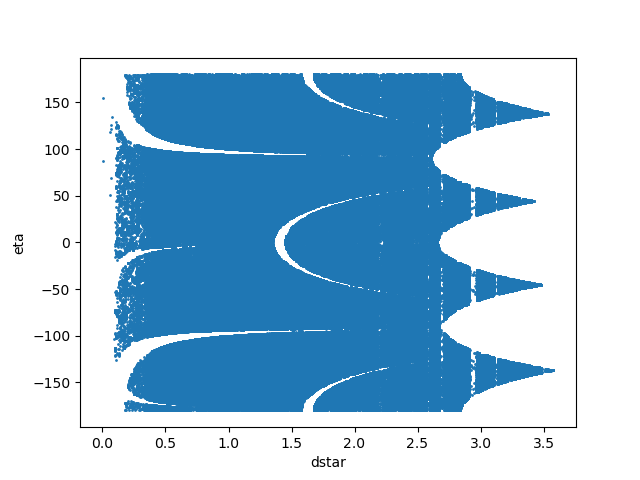

In [12]:
# plot the 4D peaks (fewer of them) as a cake (two-theta vs eta)
# if the parameters in the par file are good, these should look like straight lines

fig, ax = plt.subplots()

ax.scatter(cf_4d.ds, cf_4d.eta, s=1)

ax.set_xlabel("dstar")
ax.set_ylabel("eta")

plt.show()

In [13]:
# OPTIONAL: export CF to an flt so we can play with it with ImageD11_gui
# uncomment the below line

# cf_4d.writefile(f'{sample}_{dataset}_4d_peaks.flt')

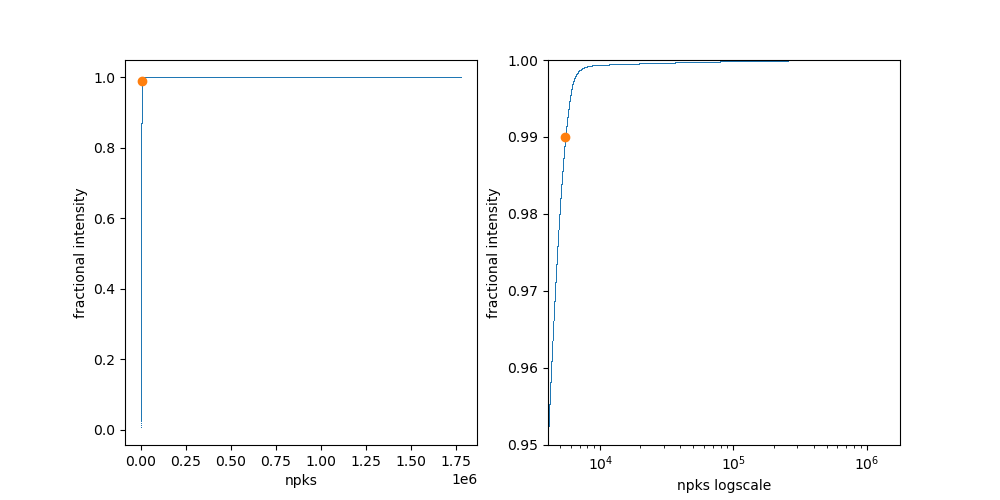

11722880
5472


In [14]:
# here we are filtering our peaks (cf_4d) to select only the strongest ones for indexing purposes only!
# dsmax is being set to limit rings given to the indexer - 6-8 rings is normally good

# USER: modify the "frac" parameter below and re-run the cell until the orange dot sits nicely on the "elbow" of the blue line
# this indicates the fractional intensity cutoff we will select
# if the blue line does not look elbow-shaped in the logscale plot, try changing the "doplot" parameter (the y scale of the logscale plot) until it does

cf_strong = utils.selectpeaks(cf_4d, frac=0.99, dsmax=1.4, doplot=0.95)
print(cf_4d.nrows)
print(cf_strong.nrows)

In [15]:
# OPTIONAL: export CF to an flt so we can play with it with ImageD11_gui
# uncomment the below line

# cf_strong.writefile(f'{sample}_{dataset}_strong_4d_peaks.flt')

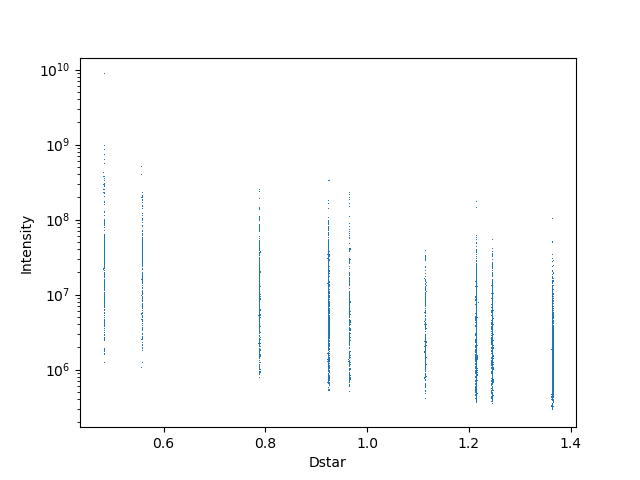

In [16]:
# now we can take a look at the intensities of the remaining peaks

fig, ax = plt.subplots()

ax.plot(cf_strong.ds, cf_strong.sum_intensity,',')
ax.semilogy()

ax.set_xlabel("Dstar")
ax.set_ylabel("Intensity")

plt.show()

In [17]:
# now we can define a unit cell from our parameters

Fe = ImageD11.unitcell.unitcell_from_parameters(cf_strong.parameters)
Fe.makerings(cf_strong.ds.max())

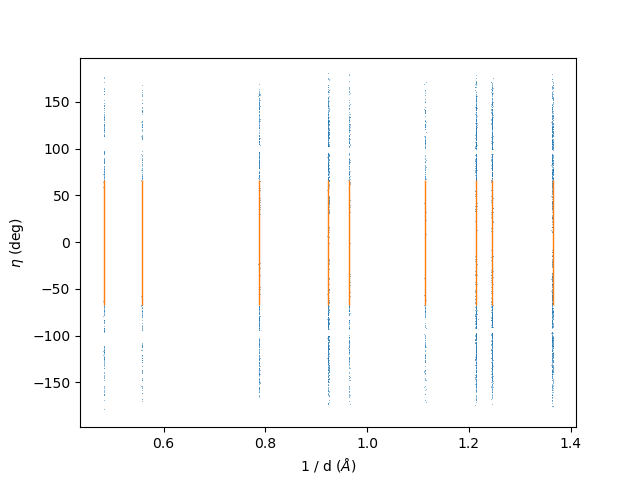

In [18]:
# now let's plot our peaks again, with the rings from the unitcell included, to check our lattice parameters are good

fig, ax = plt.subplots()

skip=1
ax.plot( cf_strong.ds[::skip], cf_strong.eta[::skip],',',alpha=0.5)
ax.plot( Fe.ringds, [0,]*len(Fe.ringds), '|', ms=90 )
ax.set_xlabel('1 / d ($\AA$)')
ax.set_ylabel('$\\eta$ (deg)')

plt.show()

In [19]:
# specify our ImageD11 indexer with these peaks
# we're aiming to index around 3_000 to 10_000 peaks

indexer = ImageD11.indexing.indexer_from_colfile(cf_strong)

print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[ 0.01952622  0.01043479 -0.48256958]
 [-0.1374559  -0.40972928  0.21048648]
 [ 0.49642473 -0.02253264 -0.24673739]
 ...
 [ 0.58974182  1.09412189 -0.56234162]
 [ 0.38176505 -1.25778619 -0.36129819]
 [ 0.83145511 -0.79825518 -0.72700321]] (5472, 3) float64
Indexing 5472 peaks


In [20]:
# USER: set a tolerance in d-space (for assigning peaks to powder rings)

indexer.ds_tol = 0.01

# change the log level so we can see what the ring assigments look like

ImageD11.indexing.loglevel = 1

# assign peaks to powder rings

indexer.assigntorings()

# change log level back again

ImageD11.indexing.loglevel = 3

info: Assign to rings, maximum d-spacing considered: 1.366357
info: Ring assignment array shape (5472,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 8   ( -4, -2, -2)   24    915       0      915   N/A     N/A  14.88
info: Ring 7   ( -4, -2,  0)   24    946       0      946   N/A     N/A  13.57
info: Ring 6   ( -3, -3, -1)   24    970       0      970   N/A     N/A  13.23
info: Ring 5   ( -4,  0,  0)    6    264       0      264   N/A     N/A  12.13
info: Ring 4   ( -2, -2, -2)    8    359       0      359   N/A     N/A  10.50
info: Ring 3   ( -3, -1, -1)   24    979       0      979   N/A     N/A  10.06
info: Ring 2   ( -2, -2,  0)   12    513       0      513   N/A     N/A  8.57
info: Ring 1   ( -2,  0,  0)    6    225       0      225   N/A     N/A  6.06
info: Ring 0   ( -1, -1, -1)    8    301       0      301   N/A     N/A  5.25
info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scor

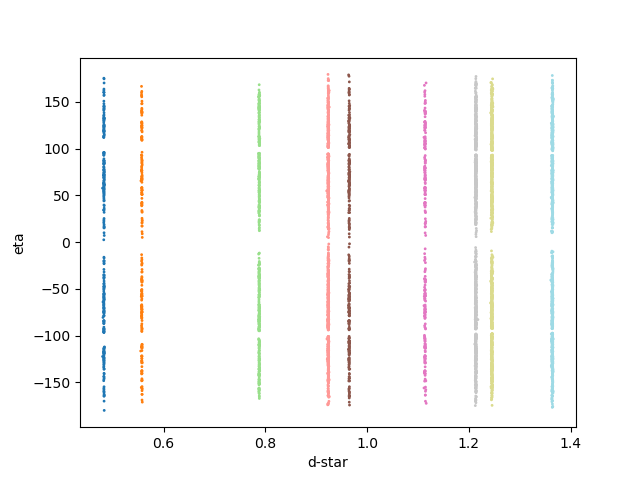

In [21]:
# let's plot the assigned peaks

fig, ax = plt.subplots()

# indexer.ra is the ring assignments

ax.scatter(cf_strong.ds, cf_strong.eta, c=indexer.ra, cmap='tab20', s=1)
ax.set_xlabel("d-star")
ax.set_ylabel("eta")

plt.show()

In [22]:
# now we are indexing!

max_multiplicity = 13

min_counts_on_ring = 0

n_peaks_expected = 0
rings = []
for i, dstar in enumerate(indexer.unitcell.ringds):
    multiplicity = len(indexer.unitcell.ringhkls[indexer.unitcell.ringds[i]])
    counts_on_this_ring = (indexer.ra == i).sum()
    if counts_on_this_ring > min_counts_on_ring:
        n_peaks_expected += multiplicity
        if multiplicity < max_multiplicity:
            rings.append((counts_on_this_ring, multiplicity, i))
        
rings.sort()
print(f"{n_peaks_expected} peaks expected")
print(f"Trying these rings (counts, multiplicity, ring number): {rings}")

# USER: specify the HKL tolerances you want to use for indexing
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.1]
# hkl_tols_seq = [0.02]   # maybe faster

# USER: specify the fraction of the total expected peaks
fracs = [0.9, 0.8, 0.7, 0.6, 0.5]
# fracs = [0.5]

# ImageD11.cImageD11.cimaged11_omp_set_num_threads(1)
ImageD11.indexing.loglevel=3

# indexer.uniqueness = 0.3
indexer.cosine_tol = np.cos(np.radians(90.25))
indexer.max_grains = 1000

# iterate over HKL tolerances
for frac in fracs:
    for tol in hkl_tols_seq:
        indexer.minpks = n_peaks_expected*frac
        indexer.hkl_tol = tol
        # iterate over rings
        
        for i in range(len(rings)):
            for j in range(i, len(rings)):
                indexer.ring_1 = rings[i][2]
                indexer.ring_2 = rings[j][2]
        
                indexer.find()
                indexer.scorethem()                

        print(frac, tol, len(indexer.ubis))

136 peaks expected
Trying these rings (counts, multiplicity, ring number): [(225, 6, 1), (264, 6, 5), (301, 8, 0), (359, 8, 4), (513, 12, 2)]
0.9 0.01 13
0.9 0.02 18
0.9 0.03 26
0.9 0.04 29
0.9 0.05 33
0.9 0.06 33
0.9 0.1 36
0.8 0.01 36
0.8 0.02 36
0.8 0.03 36
0.8 0.04 36
0.8 0.05 36
0.8 0.06 36
0.8 0.1 38
0.7 0.01 38
0.7 0.02 38
0.7 0.03 38
0.7 0.04 38
0.7 0.05 38
0.7 0.06 38
0.7 0.1 39
0.6 0.01 39
0.6 0.02 39
0.6 0.03 39
0.6 0.04 39
0.6 0.05 39
0.6 0.06 39
0.6 0.1 39
0.5 0.01 39
0.5 0.02 40
0.5 0.03 40
0.5 0.04 40
0.5 0.05 40
0.5 0.06 40
0.5 0.1 43


In [23]:
# create grain objects
grains = [ImageD11.grain.grain(ubi, translation=np.array([0., 0., 0.])) for ubi in indexer.ubis]

# set grain GIDs (useful if we ever delete a grain)
for i, g in enumerate(grains):
    g.gid = i
    
    g.a = np.cbrt(np.linalg.det(g.ubi))

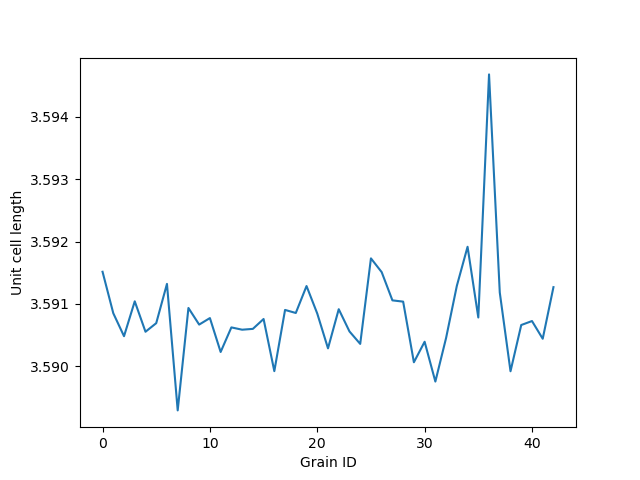

3.5907578987741244


In [24]:
mean_unit_cell_lengths = [grain.a for grain in grains]

fig, ax = plt.subplots()
ax.plot(mean_unit_cell_lengths)
ax.set_xlabel("Grain ID")
ax.set_ylabel("Unit cell length")
plt.show()

a0 = np.median(mean_unit_cell_lengths)
    
print(a0)

In [25]:
# assign peaks to grains

tol = 0.05

# column to store the grain labels
labels = np.zeros(cf_strong.nrows, 'i')
# get all g-vectors from columnfile
gv = np.transpose((cf_strong.gx,cf_strong.gy,cf_strong.gz)).astype(float)
# column to store drlv2 (error in hkl)
drlv2 =  np.ones(cf_strong.nrows, 'd')
# iterate over all grains
print(f"Scoring and assigning {len(grains)} grains")
for g in tqdm(grains):
    n = ImageD11.cImageD11.score_and_assign(g.ubi, gv, tol, drlv2, labels, g.gid)

# add the labels column to the columnfile
cf_strong.addcolumn(labels, 'grain_id')

print("Storing peak data in grains")
# iterate through all the grains
for g in tqdm(grains):
    # store this grain's peak indices so we know which 4D peaks we used for indexing
    g.peaks_4d = cf_strong.index[cf_strong.grain_id == g.gid]

Scoring and assigning 43 grains


  0%|          | 0/43 [00:00<?, ?it/s]

Storing peak data in grains


  0%|          | 0/43 [00:00<?, ?it/s]

In [26]:
def plot_index_results(ind, colfile, title):
    # Generate a histogram of |drlv| for a ubi matrix
    indexer.histogram_drlv_fit()
    # indexer.fight_over_peaks()
    
    fig, axs = plt.subplots(3, 2, layout="constrained", figsize=(9,12))
    axs_flat = axs.ravel()
    
    # For each grain, plot the error in hkl vs the number of peaks with that error
    
    for grh in ind.histogram:
        axs_flat[0].plot(ind.bins[1:-1], grh[:-1], "-")
    
    axs_flat[0].set(ylabel="number of peaks",
                    xlabel="error in hkl (e.g. hkl versus integer)",
                    title=title)
    
    # set a mask of all non-assigned g-vectors
    
    m = ind.ga == -1
    # m = colfile.grain_id == -1
    
    # plot the assigned g-vectors omega vs dty (sinograms)
    
    axs_flat[1].scatter(colfile.omega[~m],
                        colfile.dty[~m],
                        c=ind.ga[~m],
                        s=2,
                        cmap='tab20')
    
    axs_flat[1].set(title=f'Sinograms of {ind.ga.max()+1} grains',
                    xlabel='Omega/deg',
                    ylabel='dty/um')
    
    # Define weak peaks as all non-assigned peaks with intensity 1e-4 of max
    cut = colfile.sum_intensity[m].max() * 1e-4
    weak = colfile.sum_intensity[m] < cut
    
    # Plot unassigned peaks in omega vs dty
    
    axs_flat[2].scatter(colfile.omega[m][weak],  colfile.dty[m][weak],  s=2, label='weak')
    axs_flat[2].scatter(colfile.omega[m][~weak], colfile.dty[m][~weak], s=2, label='not weak')
    
    axs_flat[2].set(title='Sinograms of unassigned peaks',
                    xlabel='Omega/deg',
                    ylabel='dty/um')
    axs_flat[2].legend()
    
    # Plot d-star vs intensity for all assigned peaks
    
    axs_flat[3].scatter(colfile.ds[~m], colfile.sum_intensity[~m], s=2)
    axs_flat[3].set(title='Intensity of all assigned peaks',
                    xlabel='d-star',
                    ylabel='Intensity',
                    yscale='log')
    
    # Plot d-star vs intensity for all unassigned peaks
    
    axs_flat[4].scatter(colfile.ds[m][weak],  colfile.sum_intensity[m][weak],  s=2, label='weak')
    axs_flat[4].scatter(colfile.ds[m][~weak], colfile.sum_intensity[m][~weak], s=2, label='not weak')
    
    axs_flat[4].set(title='Intensity of all unassigned peaks',
                    xlabel='d-star',
                    ylabel='Intensity',
                    yscale='log')
    axs_flat[4].legend()
    
    # Get the number of peaks per grain
    
    npks = [(colfile.grain_id == i).sum() for i in range(len(ind.ubis))]
    
    # Plot histogram of number of peaks per grain
    
    axs_flat[5].hist(npks, bins=32)
    axs_flat[5].set(title='Hist of peaks per grain',
                    xlabel='Number of peaks',
                    ylabel='Number of grains')
    
    for ax in axs_flat:
        ax.set_box_aspect(0.7)
    
    plt.show()

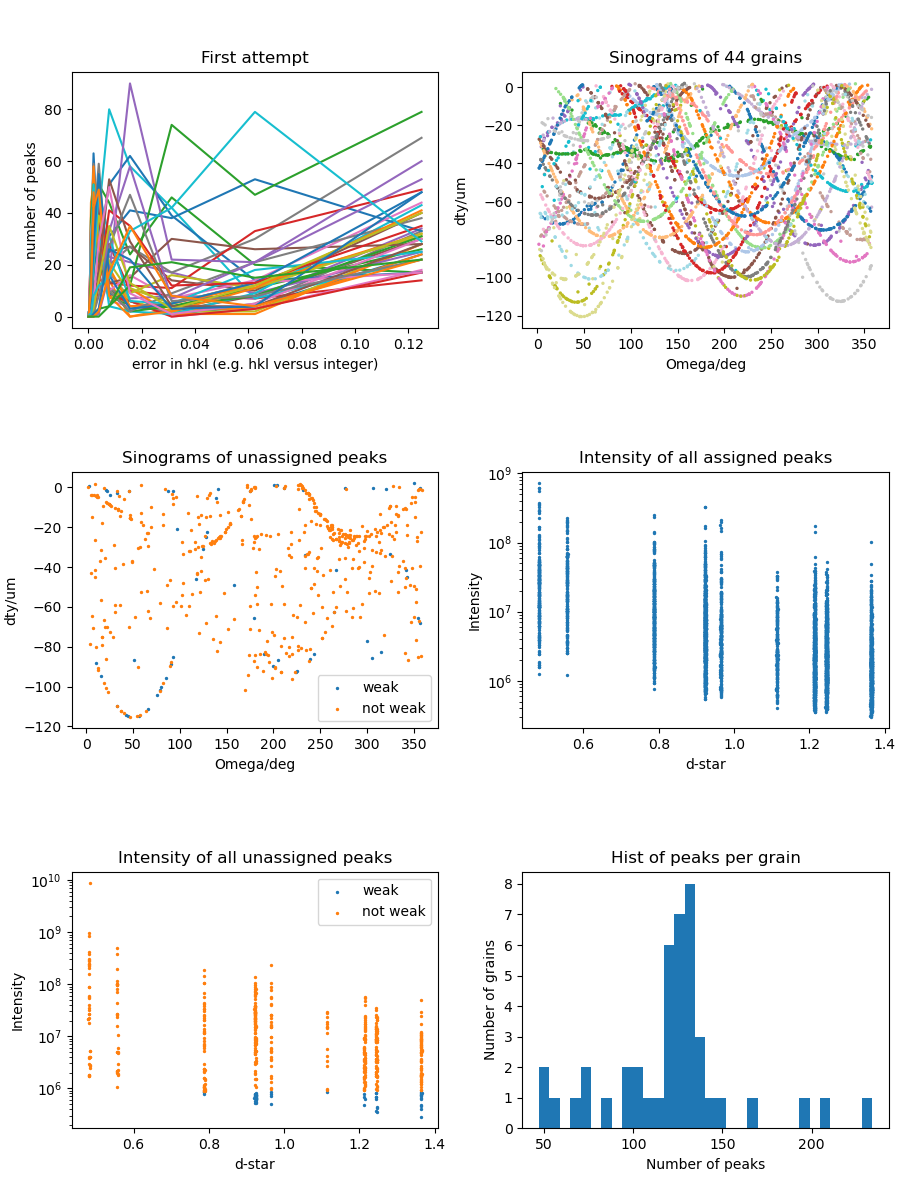

In [27]:
plot_index_results(indexer, cf_strong, 'First attempt')

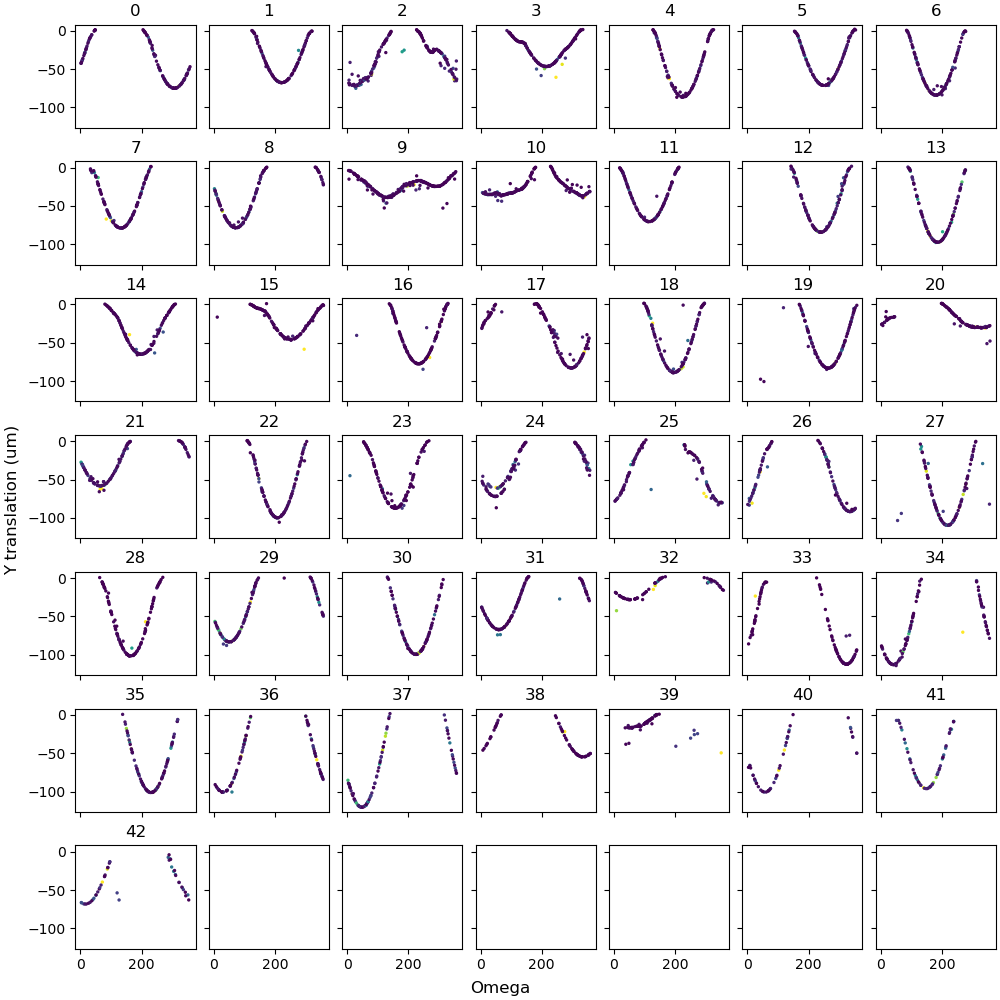

In [28]:
n_grains_to_plot=len(grains)

grains_step = len(grains)//n_grains_to_plot

grid_size = np.ceil(np.sqrt(len(grains[::grains_step]))).astype(int)
nrows = (len(grains[::grains_step])+grid_size-1)//grid_size

# plt.style.use('light_background')
fig, axs = plt.subplots(grid_size, nrows, figsize=(10,10), layout="constrained", sharex=True, sharey=True)
for i, ax in enumerate(axs.ravel()):
    if i < len(grains[::grains_step]):
    # get corresponding grain for this axis
        g = grains[::grains_step][i]
        m = cf_strong.grain_id == g.gid
        ax.scatter(cf_strong.omega[m], cf_strong.dty[m], c=cf_strong.sum_intensity[m], s=2)
        ax.set_title(g.gid)
        
fig.supxlabel("Omega")
fig.supylabel("Y translation (um)")
    
plt.show()

In [29]:
cmp = {'compression':'gzip',
       'compression_opts': 2,
       'shuffle' : True }

def save_array(grp, name, ary):
    hds = grp.require_dataset(name, 
                              shape=ary.shape,
                              dtype=ary.dtype,
                              **cmp)
    hds[:] = ary
    return hds

def save_grains(grains, ds):
    with h5py.File(ds.grainsfile, 'w') as hout:
        grn = hout.create_group('grains')
        for g in tqdm(grains):
            gg = grn.create_group(str(g.gid))
            save_array(gg, 'peaks_4d_indexing', g.peaks_4d).attrs['description'] = "Strong 4D peaks that were assigned to this grain during indexing"
            gg.attrs.update({'ubi':g.ubi})

In [30]:
# save grain data

save_grains(grains, ds)

  0%|          | 0/43 [00:00<?, ?it/s]